In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [2]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, cartesian_product

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines

# set_style()

/home/rudi/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [17]:
delta = 0.05
abs_error_eps = 1.0
epsilon = 0.5

# Online Retail

In [4]:
retail_df = pd.read_parquet("../data/clean/online_retail_no_outliers.parquet")

In [ ]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    queries = orjson.loads(f.read())

query_path = "../queries/online_retail_4_cols.json"
with open(query_path, 'rb') as f:
    queries_4 = orjson.loads(f.read())

queries["queries"] = queries["queries"]
queries_4["queries"] = queries_4["queries"]

ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


# Pacha Sketches

## Normal

In [10]:
p_sketch = PachaSketch.build_with_uniform_size(
    levels=6,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))
p_sketch.get_size()

111.24216079711914

In [11]:
p_sketch.update_data_frame(retail_df)

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]

/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [02:44<00:00, 3254.79it/s]


In [80]:
p_sketch.save_to_file("../sketches/real_world/online_retail_uniform_array.json.gz")

In [87]:
p_sketch2 = PachaSketch.from_json("../sketches/real_world/online_retail_uniform.json.gz")

In [12]:
ps_results_2 = evaluate_queries(retail_df, queries["queries"], p_sketch, path_to_file="../results/real_world/online_retail_2_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 100/100 [00:02<00:00, 43.25it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


In [13]:
ps_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,100.000000,100.000000,100.000000
mean,1525.380000,0.002843,0.027004
std,3308.341819,0.006167,0.026000
min,2.000000,0.000004,0.002201
25%,35.000000,0.000065,0.006763
50%,231.000000,0.000431,0.012551
75%,849.750000,0.001584,0.052901
max,14988.000000,0.027937,0.117547


In [14]:
ps_results_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch, path_to_file="../results/real_world/online_retail_4_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 100/100 [00:03<00:00, 32.14it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


In [16]:
ps_results_4[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,100.000000,100.000000,100.000000
mean,144.900000,0.000270,0.090180
std,370.156737,0.000690,0.141696
min,0.000000,0.000000,0.000000
25%,29.000000,0.000054,0.040741
50%,46.500000,0.000087,0.063139
75%,84.250000,0.000157,0.087078
max,2342.000000,0.004365,1.000000


## Differentially Private

In [18]:
p_sketch_dp = PachaSketch.build_with_uniform_size(
    levels=6,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01),
    epsilon=epsilon
    )
p_sketch_dp.get_size()

111.24216079711914

In [19]:
p_sketch_dp.update_data_frame(retail_df, workers=os.cpu_count())

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [02:51<00:00, 3131.78it/s]


In [20]:
ps_dp_results_2 = evaluate_queries(retail_df, queries["queries"], p_sketch_dp, path_to_file="../results/real_world/online_retail_2_p_sketch_uniform_dp_05.csv")

Computing true counts...


True Count: 100%|██████████| 100/100 [00:02<00:00, 42.94it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [03:39<00:00,  2.19s/it]


In [21]:
ps_dp_results_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch_dp, path_to_file="../results/real_world/online_retail_4_p_sketch_uniform_dp_05.csv")

Computing true counts...


True Count: 100%|██████████| 100/100 [00:03<00:00, 31.10it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


## Local Differentially Private

In [27]:
p_sketch_ldp = PachaSketch.build_with_uniform_size_ldp(
    levels=6,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01),
    epsilon=epsilon,
    n_silos=10
    )
p_sketch_ldp.get_size()

111.24216079711914

In [28]:
p_sketch_ldp.update_data_frame(retail_df)

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [02:46<00:00, 3226.12it/s]


In [29]:
ps_ldp_results_2 = evaluate_queries(retail_df, queries["queries"], p_sketch_ldp, path_to_file="../results/real_world/online_retail_2_p_sketch_uniform_ldp_05.csv")

Computing true counts...


True Count: 100%|██████████| 100/100 [00:02<00:00, 44.49it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


In [30]:
ps_ldp_results_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch_ldp, path_to_file="../results/real_world/online_retail_4_p_sketch_uniform_ldp_05.csv")

Computing true counts...


True Count: 100%|██████████| 100/100 [00:03<00:00, 31.76it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


# Baselines

## Central DP

In [43]:
# epsilon = 0.5*(len(queries["queries"])+1)
# per_query_epsilon=0.5

epsilon = 0.5
per_query_epsilon=0.5/(len(queries["queries"])+1)
central_dp = CentralDPServer(retail_df, epsilon=epsilon, per_query_epsilon=per_query_epsilon)

central_dp_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=central_dp, path_to_file="../results/real_world/online_retail_2_central_dp_05.csv")
central_dp.reset_budget()
central_dp_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=central_dp, path_to_file="../results/real_world/online_retail_4_central_dp_05.csv")
central_dp.reset_budget()

Computing true counts...


True Count: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


Computing true counts...


True Count: 100%|██████████| 100/100 [00:05<00:00, 19.52it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:05<00:00, 19.97it/s]


In [90]:
central_dp_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,41.945000,0.000077,0.010200
std,43.599271,0.000080,0.025772
min,0.000000,0.000000,0.000000
25%,12.000000,0.000022,0.000342
50%,32.000000,0.000059,0.002145
75%,58.250000,0.000107,0.009703
max,267.000000,0.000493,0.261324


In [91]:
central_dp_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,196.000000
mean,42.135000,0.000078,inf
std,41.330836,0.000076,NaN
min,0.000000,0.000000,0.000045
25%,11.750000,0.000022,0.010163
50%,28.000000,0.000052,0.029956
75%,60.000000,0.000111,0.092788
max,229.000000,0.000423,inf


## Local DP

In [41]:
# epsilon = 0.5*(len(queries["queries"])+1)
# per_query_epsilon=0.5

epsilon = 0.5
per_query_epsilon=0.5/(len(queries["queries"])+1)
ldp = LDPServer(retail_df, epsilon=epsilon, number_of_partitions=10, per_query_epsilon=per_query_epsilon)

ldp_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file="../results/real_world/online_retail_2_ldp_05.csv")
ldp.reset_budget()
ldp_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=ldp, path_to_file="../results/real_world/online_retail_4_ldp_05.csv")
ldp.reset_budget()

Computing true counts...


True Count:   0%|          | 0/100 [00:00<?, ?it/s]

True Count: 100%|██████████| 100/100 [00:03<00:00, 26.42it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:04<00:00, 22.32it/s]


Computing true counts...


True Count: 100%|██████████| 100/100 [00:05<00:00, 19.63it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


In [93]:
ldp_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,39521.200000,0.072930,0.840484
std,54223.788555,0.100061,0.209928
min,56.000000,0.000103,0.050088
25%,2936.250000,0.005418,0.794086
50%,5668.500000,0.010460,0.930375
75%,79390.000000,0.146501,0.977298
max,191591.000000,0.353548,1.000000


In [94]:
ldp_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,198.000000
mean,2883.770000,0.005322,inf
std,7874.113824,0.014530,NaN
min,0.000000,0.000000,0.141414
25%,347.750000,0.000642,0.885487
50%,836.500000,0.001544,0.998182
75%,1569.500000,0.002896,1.000000
max,45603.000000,0.084153,inf


## Local DP - GRR

In [33]:
epsilon = 0.5
categorical_domains, numerical_ranges = infer_domains_and_ranges(retail_df)

grr = LDPEncoderGRR(df=retail_df, epsilon=epsilon, categorical_domains=categorical_domains, numerical_ranges=numerical_ranges)

grr_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=grr, path_to_file="../results/real_world/online_retail_2_grr_05.csv")
grr_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=grr, path_to_file="../results/real_world/online_retail_4_grr_05.csv")

Privatizing rows: 100%|██████████| 536494/536494 [00:48<00:00, 11037.64it/s]


Computing true counts...


True Count: 100%|██████████| 100/100 [00:02<00:00, 41.47it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Computing true counts...


True Count: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:04<00:00, 20.23it/s]


In [96]:
grr_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,44468.655000,0.082059,0.930654
std,62673.184972,0.115653,0.257347
min,16.000000,0.000030,0.042328
25%,3323.750000,0.006133,0.887105
50%,6230.500000,0.011497,0.960060
75%,83535.000000,0.154149,0.987321
max,219330.000000,0.404736,4.100422


In [97]:
grr_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,196.00000
mean,2962.560000,0.005467,inf
std,7907.365946,0.014592,NaN
min,0.000000,0.000000,0.00000
25%,413.250000,0.000763,0.99875
50%,963.500000,0.001778,1.00000
75%,1700.750000,0.003138,1.00000
max,45572.000000,0.084095,inf


# Plots

In [48]:
level_cols = [f'level_{L}_queries' for L in range(6)]
for L, col in enumerate(level_cols):
    ps_results_2[f'level_{L}_volume'] = ps_results_2[col] / (2 ** (3 * L))
ps_results_2['total_volume'] = ps_results_2[[f'level_{L}_volume' for L in range(6)]].sum(axis=1)

for L, col in enumerate(level_cols):
    ps_results_2[f'level_{L}_relative_volume'] = ps_results_2[f'level_{L}_volume'] / ps_results_2['total_volume'] 

In [50]:
ps_results_2[['level_0_relative_volume', 'level_1_relative_volume', 'level_2_relative_volume',
              'level_3_relative_volume', 'level_4_relative_volume', 'level_5_relative_volume']].describe()

,level_0_relative_volume,level_1_relative_volume,level_2_relative_volume,level_3_relative_volume,level_4_relative_volume,level_5_relative_volume
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.524109,0.416067,0.054095,0.005630,0.000088,0.000011
std,0.389781,0.339816,0.054128,0.006831,0.000179,0.000019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021953,0.110915,0.010987,0.000000,0.000000,0.000000
50%,0.672940,0.292985,0.030891,0.002574,0.000000,0.000003
75%,0.869735,0.826902,0.109089,0.011464,0.000080,0.000012
max,0.984703,0.901844,0.185010,0.027945,0.000784,0.000095


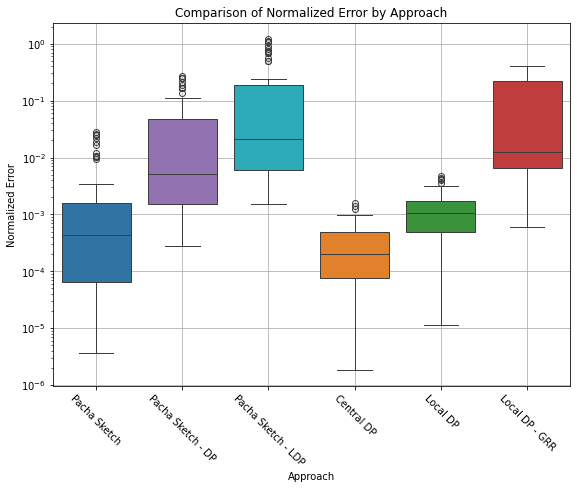

In [53]:
# Label the sources as '2' and '4' (corresponding to number of predicates)
ps_results_2['approach'] = 'Pacha Sketch'
ps_dp_results_2['approach'] = 'Pacha Sketch - DP'
ps_ldp_results_2['approach'] = 'Pacha Sketch - LDP'
central_dp_results_2['approach'] = 'Central DP'
ldp_results_2['approach'] = 'Local DP'
grr_results_2['approach'] = 'Local DP - GRR'

custom_palette = {
    'Pacha Sketch': 'tab:blue',
    'Pacha Sketch - DP': 'tab:purple',
    'Pacha Sketch - LDP': 'tab:cyan', 
    'Central DP': 'tab:orange',
    'Local DP': 'tab:green',
    'Local DP - GRR': 'tab:red'
    }

# Combine the DataFrames
combined_df = pd.concat([ps_results_2, ps_dp_results_2,ps_ldp_results_2, central_dp_results_2, ldp_results_2, grr_results_2], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='approach', y='normalized_error', hue='approach', data=combined_df, palette=custom_palette)

# Set axis labels and title
plt.xlabel('Approach')
plt.ylabel('Normalized Error')
plt.title('Comparison of Normalized Error by Approach')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')  
plt.xticks(rotation=-45)
plt.show()

In [119]:
CMParameters(width=10, depth=3, epsilon=5.0/200.0).build_sketch().counters

array([[ 125,    3,    0,  -77,  -25,    0,   18,   37,  -11,  -81],
       [ -22,   68,  -34,   -4,   79, -120,    9,   92,  -31,    4],
       [  68,  -53,    2,   28,   17,   -3,  -36,   -1,  -12,   -2]])

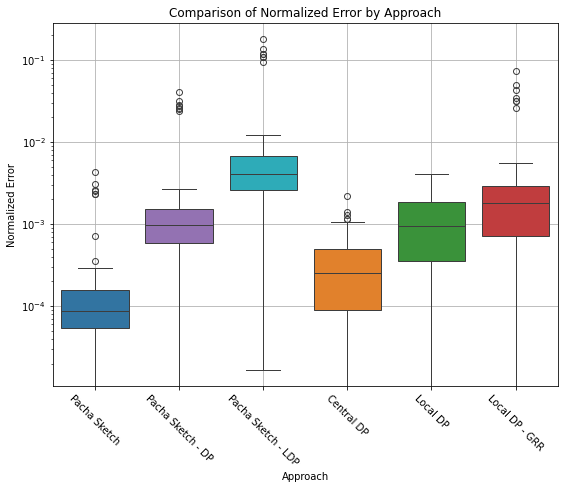

In [45]:
# Label the sources as '2' and '4' (corresponding to number of predicates)
ps_results_4['approach'] = 'Pacha Sketch'
ps_dp_results_4['approach'] = 'Pacha Sketch - DP'
ps_ldp_results_4['approach'] = 'Pacha Sketch - LDP'
central_dp_results_4['approach'] = 'Central DP'
ldp_results_4['approach'] = 'Local DP'
grr_results_4['approach'] = 'Local DP - GRR'

custom_palette = {
    'Pacha Sketch': 'tab:blue',
    'Pacha Sketch - DP': 'tab:purple',
    'Pacha Sketch - LDP': 'tab:cyan', 
    'Central DP': 'tab:orange',
    'Local DP': 'tab:green',
    'Local DP - GRR': 'tab:red'
    }

# Combine the DataFrames
combined_df = pd.concat([ps_results_4, ps_dp_results_4,ps_ldp_results_4, central_dp_results_4, ldp_results_4, grr_results_4], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='approach', y='normalized_error', hue='approach', data=combined_df, palette=custom_palette)

# Set axis labels and title
plt.xlabel('Approach')
plt.ylabel('Normalized Error')
plt.title('Comparison of Normalized Error by Approach')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')  
plt.xticks(rotation=-45)
plt.show()

# Performance Improvements

In [362]:
p_sketch_new = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))

In [363]:
for i, bm in enumerate(p_sketch.numerical_bitmaps):
    p_sketch_new.numerical_bitmaps[i].exponent = bm.exponent
    p_sketch_new.numerical_bitmaps[i].bucket_size = bm.bucket_size
    p_sketch_new.numerical_bitmaps[i].base = bm.base
    p_sketch_new.numerical_bitmaps[i].positive_bitmap = bm.positive_bitmap
    p_sketch_new.numerical_bitmaps[i].negative_bitmap = bm.negative_bitmap
    p_sketch_new.numerical_bitmaps[i].size_per_side = bm.size_per_side
    p_sketch_new.numerical_bitmaps[i].limit = bm.limit
# p_sketch_new.numerical_bitmaps = p_sketch.numerical_bitmaps

In [364]:
result_array = p_sketch_new.minimal_spatial_b_adic_cover_array(test_region)

In [365]:
len(result_array)

240926

In [ ]:
b_cubes = p_sketch.minimal_spatial_b_adic_cover([[93, 170], (18, 71), (0, 168469)])


In [342]:
import time

# Define the test input
test_region = [[93, 170], (18, 71), (0, 168469)]

# Time the original method
start_time = time.time()
result_old = p_sketch.minimal_spatial_b_adic_cover(test_region)
old_time = time.time() - start_time

# Time the new method
start_time = time.time()
result_new = p_sketch_new.new_minimal_spatial_b_adic_cover(test_region)
new_time = time.time() - start_time

start_time = time.time()
result_array = p_sketch_new.minimal_spatial_b_adic_cover_array(test_region)
array_time = time.time() - start_time

# Compare results for equivalence
are_equivalent = (result_old == result_new)

print(f"Old method time: {old_time:.6f} seconds")
print(f"New method time: {new_time:.6f} seconds")
print(f"Array method time: {array_time:.6f} seconds")
print(f"Results equivalent: {are_equivalent}")
print(f"Number of B-adic cubes: {len(result_old), len(result_new), len(result_array)}")


Old method time: 7.607994 seconds
New method time: 5.088587 seconds
Array method time: 0.017456 seconds
Results equivalent: [ True  True  True ...  True  True  True]
Number of B-adic cubes: (240926, 240926, 240926)


In [346]:
# Assuming result_old is a numpy array of BAdicCube objects
# Each BAdicCube has attributes: level and indeces (tuple of ints)

def badicube_to_array(badicubes):
    # badicubes: array-like of BAdicCube
    # Returns: np.ndarray of shape (n, 1 + len(indeces))
    arr = np.array([
        (cube.level, *cube.indeces)
        for cube in badicubes
    ])
    return arr

badicube_array = badicube_to_array(result_old)
print(badicube_array.shape)
print(badicube_array[:5])

(240926, 4)
[[ 0 93 18  0]
 [ 0 93 18  1]
 [ 0 93 18  2]
 [ 0 93 18  3]
 [ 0 93 18  4]]


In [382]:
# def get_relevant_nodes_array(ad_tree, predicates, for_query=False) -> np.ndarray:
predicates=[{'*'}, {'France'}, {'*'}]
if len(predicates) != ad_tree.num_dimensions:
    raise ValueError("Predicates length does not match the number of dimensions.")

# if predicates == list({"*"} for _ in range(ad_tree.num_dimensions)):
#     return [tuple("*" for _ in range(ad_tree.num_dimensions))]

last_predicate = ad_tree.num_dimensions - 1
for predicate in reversed(predicates):
    if predicate != {"*"}:
        break
    last_predicate -= 1

for i in range(ad_tree.num_dimensions):
    if predicates[i] == {"*"}:
        if i < last_predicate:
            predicates[i] = ad_tree.possible_values[i]
        continue
    elif not predicates[i].issubset(ad_tree.possible_values[i]):
        raise ValueError(f"Predicate {predicates[i]} at index {i} is not in the possible values.")

# Use NumPy for cartesian product


# if not for_query:
#     relevant_nodes = np.vstack([tuple("*" for _ in range(ad_tree.num_dimensions)), relevant_nodes])

    # return relevant_nodes 

In [388]:
arrays = [np.array(list(p)) for p in predicates]
mesh = np.meshgrid(*arrays, indexing="ij")
flat = np.stack(mesh, axis=-1).reshape(-1, ad_tree.num_dimensions)
relevant_nodes = [tuple(row) for row in flat]

In [397]:
len(ad_tree.get_relevant_nodes_array([{'*'}, {'France'}, {'*'}], for_query=True))

125

In [395]:
rel_nodes = p_sketch_new.ad_tree.get_relevant_nodes([{'*'}, {'France'}, {'*'}])

In [399]:
query_regions = np.asarray([['*', '*', '*', 1, 2, 3],
            ['*', '*', '*', 1, 2, 4],
            ['*', '*', '*', 1, 2, 5],
            ['*', '*', '*', 2, 3, 3],
            ['*', '*', '*', 2, 3, 4]])

In [ ]:
levels = 5
bases = np.asarray([2, 2, 2], dtype=int)
element = np.asarray([1, 2, 3], dtype=int)

all_levels = np.arange(levels)

In [413]:
num_mappings = []
for level in range(levels):
    b_adic_ranges = []
    for i, base in enumerate(bases):
        b_adic_ranges.append(BAdicRange(base, level, element[i] // base**level))
    num_mappings.append(BAdicCube(b_adic_ranges))

In [427]:
# bases and all_levels are already defined in cell 55
# bases: np.ndarray of shape (3,) with values [2, 2, 2]
# all_levels: np.ndarray of shape (5,) with values [0, 1, 2, 3, 4]

# Compute the matrix where each cell is bases ** all_levels
matrix = bases[:, None] ** all_levels[None, :]
cubes = np.floor(element[:, None] / matrix[0, :]).astype(int)
print(np.vstack([all_levels[:, None], cubes.T]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 3

In [428]:
np.column_stack([all_levels, cubes.T])

array([[0, 1, 2, 3],
       [1, 0, 1, 1],
       [2, 0, 0, 0],
       [3, 0, 0, 0],
       [4, 0, 0, 0]])

In [421]:
num_mappings

[BAdicCube(bases=(2, 2, 2), level=0, indeces=(1, 2, 3)),
 BAdicCube(bases=(2, 2, 2), level=1, indeces=(0, 1, 1)),
 BAdicCube(bases=(2, 2, 2), level=2, indeces=(0, 0, 0)),
 BAdicCube(bases=(2, 2, 2), level=3, indeces=(0, 0, 0)),
 BAdicCube(bases=(2, 2, 2), level=4, indeces=(0, 0, 0))]

In [406]:
np.asarray([('*', '*', '*'), ('*', '*', '*'), ('*', '*', '*')])

array([['*', '*', '*'],
       ['*', '*', '*'],
       ['*', '*', '*']], dtype='<U1')

In [360]:
[hash(tuple(val)) for val in np.asarray(rel_nodes)]

[-6369975529614288558,
 5232533906751378970,
 -5071030604092948102,
 1809467772968732216,
 -2359857282008225136,
 1888784957364193609,
 7587066775183003426,
 207939327853269914,
 -6306635221017925988,
 3457098219362671120,
 7947468953557346695,
 -5035502041935406681,
 454023946504616242,
 4402880704068234458,
 -3903412620359786380,
 6241984740828599253,
 8643386876762453262,
 -8853514264951912250,
 -4340151331073075588,
 70147821319762893,
 153051910942655200,
 1774741698661199909,
 3935330896207654221,
 6428147012758078230,
 -5859787539302264284,
 2452702191699536075,
 -699899837822465057,
 5606691342817734429,
 -9131013447521673732,
 2359319989459239802,
 -1214500100187482111,
 -7442215466746353801,
 -7592077228266645601,
 -6538292622383240900,
 1419297611110391312,
 2817701366301346130,
 -3012049416590788066,
 3579080440426215660,
 -1238323115115579217,
 3663354385479941344,
 304780146055736053,
 2359791114716061915,
 5598801675400939141,
 944734019951195201,
 596035380402092192,
 7

In [358]:
[hash(tuple(val)) for val in np.asarray(rel_nodes)]

[-6369975529614288558,
 1662205864044147147,
 1916536311189106074,
 -1760860269738499607,
 -5930185324715456959,
 -8727572373977895039,
 4016738732475771603,
 -3362388714853961909,
 8569780809984393805,
 -113229823344560703,
 -7910065587854518873,
 -8605830084642638504,
 7441590861786670418,
 832552661361002635,
 3926974122007676588,
 -4374372590513489395,
 -1972970454579635386,
 -1865947349669858074,
 -7910479373780307411,
 -3500180221387468930,
 -9147851329572399325,
 -8841615632680888739,
 365002853500422398,
 -4188210318584010418,
 9016628491700055509,
 -9006474966727961365,
 7130486904544997911,
 2036363300110502606,
 -8302984107244537427,
 -3429717581701385549,
 1374709432110203937,
 388171275621109167,
 7284338802735674192,
 1292094119984222068,
 8406864526392445488,
 -7798655965040742518,
 -6582377459298019889,
 8752397718983837,
 -4808651157822811040,
 -6953002945862147304,
 2893989678353422101,
 -8256566216626026733,
 -5017555655941149507,
 -5273265928406525319,
 -29742926623

In [186]:
bm = p_sketch.numerical_bitmaps[2]

In [262]:
import time

# Benchmark downgrade_b_adic_range vs downgrade_b_adic_range_indices
b_range = BAdicRange(2, 17, 0)

# Time downgrade_b_adic_range (returns list of BAdicRange)
start = time.time()
downgraded_ranges = b_range.downgrade_b_adic_range(0)
time_downgrade_range = time.time() - start

# Time downgrade_b_adic_range_indices (returns np.ndarray of indices)
start = time.time()
b_adic_indices = downgrade_b_adic_range_indices(base=b_range.base, level=b_range.level, idx=b_range.index, new_level=0)
time_downgrade_indices = time.time() - start

print(f"downgrade_b_adic_range(0): {time_downgrade_range:.6f} seconds, {len(downgraded_ranges)} ranges")
print(f"downgrade_b_adic_range_indices(...): {time_downgrade_indices:.6f} seconds, {len(b_adic_indices)} indices")

# Benchmark prune_b_adic vs prune_b_adic_indices
# prune_b_adic returns list of BAdicRange, prune_b_adic_indices returns np.ndarray of indices
start = time.time()
unpruned_ranges = prune_b_adic(bm, downgraded_ranges)
time_prune_ranges = time.time() - start

start = time.time()
unpruned_indices = prune_b_adic_indices(bm, 0, b_adic_indices)
time_prune_indices = time.time() - start

print(f"prune_b_adic: {time_prune_ranges:.6f} seconds, {len(unpruned_ranges)} unpruned")
print(f"prune_b_adic_indices: {time_prune_indices:.6f} seconds, {len(unpruned_indices)} unpruned")

downgrade_b_adic_range(0): 0.183764 seconds, 131072 ranges
downgrade_b_adic_range_indices(...): 0.000654 seconds, 131072 indices
prune_b_adic: 0.192881 seconds, 1506 unpruned
prune_b_adic_indices: 0.000819 seconds, 1506 unpruned


## Local DP

In [ ]:
epsilon = 5.0
per_query_epsilon=epsilon/(len(queries["queries"])+1)
ldp = LDPServer(retail_df, epsilon=epsilon, number_of_partitions=10, per_query_epsilon=per_query_epsilon)

ldp_results_2 = evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file="../results/real_world/online_retail_2_ldp_5.csv")
ldp.reset_budget()
ldp_results_4 = evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=ldp, path_to_file="../results/real_world/online_retail_4_ldp_5.csv")
ldp.reset_budget()

Computing true counts...


True Count:   0%|          | 0/200 [00:00<?, ?it/s]

True Count: 100%|██████████| 200/200 [00:04<00:00, 42.02it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:06<00:00, 31.73it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 29.51it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


In [ ]:
ldp_results_2[["absolute_error","normalized_error","relative_error"]].describe()

,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,200.000000
mean,39521.200000,0.072930,0.840484
std,54223.788555,0.100061,0.209928
min,56.000000,0.000103,0.050088
25%,2936.250000,0.005418,0.794086
50%,5668.500000,0.010460,0.930375
75%,79390.000000,0.146501,0.977298
max,191591.000000,0.353548,1.000000


In [ ]:
ldp_results_4[["absolute_error","normalized_error","relative_error"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error
count,200.000000,200.000000,198.000000
mean,2883.770000,0.005322,inf
std,7874.113824,0.014530,NaN
min,0.000000,0.000000,0.141414
25%,347.750000,0.000642,0.885487
50%,836.500000,0.001544,0.998182
75%,1569.500000,0.002896,1.000000
max,45603.000000,0.084153,inf
